In [1]:
from data.helper import *

In [2]:
PLAN_DF = get_plan_df("pfcalcul")
TRAIN_DF = get_train_df()

100%|██████████| 12800/12800 [00:04<00:00, 2953.10it/s]


In [3]:
DISPLAY = 0

COLUMNS = [
    # "data_pruning",
    "features",
    "facts",
    "optimiser",
    "multiset_hash",
    "iterations",
    "feature_pruning",
]

def get_plan_df_copy():
    df = PLAN_DF.copy()
    df = df[df.data_pruning == "equivalent-weighted"]
    return df

def get_train_df_copy():
    df = TRAIN_DF.copy()
    df = df[df.data_pruning == "equivalent-weighted"]
    return df

In [ ]:


# def limer(df, xmetric, ymetric, on, file_name):
    # fig = px.scatter(
    #     df,
    #     x=xmetric,
    #     y=ymetric,
    #     log_x=True,
    #     log_y=True,
    #     color="domain",
    #     hover_data=on,
    # )
    # # add x=y line
    # fig.add_trace(
    #     go.Scatter(x=[1, MAX], y=[1, MAX], mode="lines", line=dict(color="black", dash="dash"))
    # )
    # # square plot
    # fig.update_layout(
    #     width=800,
    #     height=800,
    # )
    # # fig.update_layout(showlegend=False)

    # # remove x y axis labels
    # fig.update_xaxes(title_text="")
    # fig.update_yaxes(title_text="")

    # # save
    # fig.write_html(PLOT_DIR + "/versus/" + file_name + ".html")

    # remove legend
    # fig.show()
    # fig.write_image("/home/dzc/manuscripts/socs-25-hyperparameters/auto_plots/versus/" + file_name + ".pdf")
    # fig.show()

features wl niwl
blocksworld childsnack ferry floortile miconic rovers satellite sokoban spanner transport 
iterations 4 1
blocksworld childsnack ferry floortile miconic rovers satellite sokoban spanner transport 
feature_pruning none collapse-layer-yf
blocksworld childsnack ferry floortile miconic rovers satellite sokoban spanner transport 
multiset_hash 1 0
blocksworld childsnack ferry floortile miconic rovers satellite sokoban spanner transport 
facts fd all
blocksworld childsnack ferry floortile miconic rovers satellite sokoban spanner transport 
optimiser svr rank-svm
blocksworld childsnack ferry floortile miconic rovers satellite sokoban spanner transport 


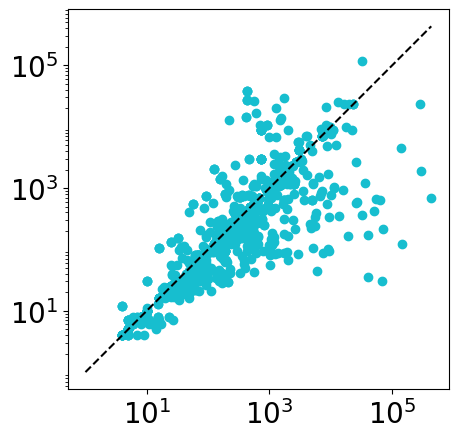

In [39]:
metric = "expanded"
pairs = {
    "features": ["wl", "niwl"],
    "iterations": ["4", "1"],
    "feature_pruning": ["none", "collapse-layer-yf"],
    "multiset_hash": ["1", "0"],
    "facts": ["fd", "all"],
    "optimiser": ["svr", "rank-svm"],
}

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def limer(df, xmetric, ymetric, on, file_name, i):
    MAX = max(df[xmetric].max(), df[ymetric].max())
    plt.clf()
    plt.scatter(
        df[xmetric],
        df[ymetric],
        color=list(mcolors.TABLEAU_COLORS)[i],
    )
    plt.plot([1, MAX], [1, MAX], color="black", linestyle="--")
    plt.yscale("log")
    plt.xscale("log")
    # general font size
    plt.rcParams.update({"font.size": 20})
    # always 3 ticks for x and y axis (doesn't work)
    # plt.locator_params(axis="x", numticks=3)
    # plt.locator_params(axis="y", numticks=3)
    # square plot layout
    plt.gca().set_aspect("equal", adjustable="box")
    # tight layout
    plt.tight_layout()
    plt.savefig("/home/dzc/manuscripts/socs-25-hyperparameters/auto_plots/versus/" + file_name + ".pdf", bbox_inches="tight")
    # plt.show()


for hyperparam, (v0, v1) in pairs.items():
    print(hyperparam, v0, v1)
    df = get_plan_df_copy()
    # df1 to be the df rows where df[df.hyperparam == v1], and df0 to be the df rows where df[df.hyperparam == v0]
    df0 = df[df[hyperparam] == v0]
    df1 = df[df[hyperparam] == v1]
    # display(df0)
    # display(df1)
    # merge df0 and df1 where rows have same everything except hyperparam
    on = ["domain", "problem"] + COLUMNS
    on.remove(hyperparam)
    df = pd.merge(df0, df1, suffixes=("_" + v0, "_" + v1), on=on)
    xmetric = metric + "_" + v0
    ymetric = metric + "_" + v1
    df = df[on + [xmetric, ymetric]]
    # display(df)
    # limer(df, xmetric, ymetric, on, file_name=f"{hyperparam}")
    for i, domain in enumerate(sorted(df.domain.unique())):
        print(domain, end=" ")
        df_domain = df[df.domain == domain]
        limer(df_domain, xmetric, ymetric, on, file_name=f"{hyperparam}-{domain}", i=i)
    print()

In [4]:
train_dfs = {}
metric = "completed"
for column_to_keep in COLUMNS:
    if DISPLAY:
        print("*"*80)
        print(column_to_keep)
        print("*"*80)
    for f in [
        # "max",
        "sum",
    ]:
        if DISPLAY:
            print(f)
        if f == "sum":
            df = get_train_df_copy()
            df = df[[metric, column_to_keep, "domain"]]
            df = df.groupby([column_to_keep] + ["domain"]).sum().reset_index()
            df = df.pivot_table(index=[column_to_keep], columns="domain", values=metric)
            df["SUM"] = df.sum(axis=1)
        else:
            df = get_train_df_copy()
            C = COLUMNS.copy() + ["domain"]
            df = df.groupby(C).sum().reset_index()
            df = df.groupby([column_to_keep] + ["domain"]).max().reset_index()
            df = df.pivot_table(index=[column_to_keep], columns="domain", values=metric)
        df = df.astype(int).reset_index()
        # display df without hiding rows
        if DISPLAY:
            with pd.option_context("display.max_rows", None):
                display(df)
        train_dfs[column_to_keep] = df
    #     break
    # break

In [5]:
plan_dfs = {}
metric = "solved"
for column_to_keep in COLUMNS:
    if DISPLAY:
        print("*"*80)
        print(column_to_keep)
        print("*"*80)
    for f in [
        "max",
        "sum",
    ]:
        if DISPLAY:
            print(f)
        if f == "sum":
            df = get_plan_df_copy()
            df = df[[metric, column_to_keep, "domain"]]
            df = df.groupby([column_to_keep] + ["domain"]).sum().reset_index()
            df = df.pivot_table(index=[column_to_keep], columns="domain", values=metric)
            df["SUM"] = df.sum(axis=1)
        else:
            df = get_plan_df_copy()
            C = COLUMNS.copy() + ["domain"]
            df = df.groupby(C).sum().reset_index()
            df = df.groupby([column_to_keep] + ["domain"]).max().reset_index()
            df = df.pivot_table(index=[column_to_keep], columns="domain", values=metric)
        df = df.astype(int).reset_index()
        # display df without hiding rows
        if DISPLAY:
            with pd.option_context("display.max_rows", None):
                display(df)
        plan_dfs[(column_to_keep, f)] = df
    #     break
    # break

In [6]:
orders = {
    "features": ["wl", "iwl", "niwl", "lwl2"],
    "iterations": ["1", "2", "3", "4", "5", "6", "7", "8"],
    "feature_pruning": ["none", "collapse-layer-yf"],
    "multiset_hash": ["1", "0"],
    "facts": ["fd", "all"],
    "optimiser": ["svr", "gpr", "rank-svm", "rank-gpc", "rank-lp"],
}

with open("/home/dzc/manuscripts/socs-25-hyperparameters/tables/results_template.tex") as f:
    content = f.read()

for column_to_keep in ["features", "iterations", "feature_pruning", "multiset_hash", "facts", "optimiser"]:
    train_df = train_dfs[column_to_keep]
    plan_df = plan_dfs[(column_to_keep, "sum")]
    df = train_df.join(plan_df, lsuffix="_train", rsuffix="_plan")
    rows = []
    for row in df.to_csv(header=False).split("\n")[:-1]:
        rows.append(row.split(",")[1:])
    rows_ordered = [[0 for _ in range(22)] for _ in range(len(orders[column_to_keep]))]
    config_to_index = {config: i for i, config in enumerate(orders[column_to_keep])}
    for row in rows:
        config = row[0]
        new_row = row[1:12] + row[13:]
        i = config_to_index[config]

        if column_to_keep == "features":
            # remove numbers from config
            config = "".join([c for c in config if not c.isdigit()])
            config = '\\' + config + "{}"
        elif column_to_keep in {"feature_pruning", "optimiser"}:
            config = config.replace("-", "")
            config = '\\' + config + "{}"
        elif column_to_keep == "multiset_hash":
            if config == "1":
                config = r"\multiset{}"
            else:
                config = r"\sset{}"
        elif column_to_keep == "facts":
            if config == "fd":
                config = r"\ppartial{}"
            else:
                config = r"\complete{}"
        elif column_to_keep == "iterations":
            config = f"\\texttt{config}"

        rows_ordered[i] = [config] + new_row
    rows_latex = ""
    for row in rows_ordered:
        rows_latex += (" & ".join(row)) + r" \\" + "\n"
    content = content.replace(f"% {column_to_keep.upper()}", rows_latex)
    if DISPLAY:
        print(column_to_keep)
        with pd.option_context("display.max_columns", None):
            display(df)

with open("/home/dzc/manuscripts/socs-25-hyperparameters/tables/results.tex", "w") as f:
    f.write(content)

In [7]:
for optimisation, iterations in product(["svr", "rank-svm"], ["2", "4"]):
    print(optimisation, iterations)
    df = get_plan_df_copy()
    df = df[df.optimiser == optimisation]
    df = df[df.iterations == iterations]
    df = df[df.solved]
    df.solved = df.solved.astype(int)

    fig = px.ecdf(df, x="runtime", color="feature_pruning", ecdfnorm=None, log_x=True)
    # hide axis labels
    fig.update_xaxes(title_text="")
    fig.update_yaxes(title_text="")
    # size
    fig.update_layout(width=600, height=400)
    # remove margins
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
    # font size
    fig.update_layout(font=dict(size=20))
    # hide legend
    # fig.update_layout(showlegend=False)

    fig.show()

svr 2


svr 4


rank-svm 2


rank-svm 4
